# Logistic regression model, feature version 2

**Motivation:** With fully prepared data (**feature selection v2** and dataset split), this script fits a **Logistic Regression** model.

**Content:**
- Load data
- Removed features with high VIF
- Fit logistic model using step function
- Fit logistic model using LASSO
- Fit logistic model using Ridge
- Save summary of fitted models
- Call python function to generate excel file (from saved summary)

**NOTE:**
- The features were selected in such a way that the presence of any feature should have a positive impact on the model’s outcome.
- Therefore, negative betas suggest a potential issue. The models will be tuned to have only positive betas.

### load data

In [1]:
# load libraries
library(glmnet)
library(car)
library(Matrix)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: carData


In [2]:
# load custom functions
source("R_functions/log_lm_summary.R")
source("R_functions/confussion_matrix.R")

In [3]:
feature_version <- 'v2_2'
response <- 'vizier'

In [4]:
# get path to data folder
# correct path should be ".../scr/data"
path_scr = dirname(dirname(getwd()))
path_data = file.path(path_scr, "data")
print(path_data)

[1] "C:/Users/Stoja/OneDrive/Documents/diplomka/scr/data"


In [5]:
# set path to train and validation data
file_train <- paste0('df_vizier_train_', feature_version, '.csv') 
file_val <- paste0('df_vizier_val_', feature_version, '.csv')
path_train <- file.path(path_data, file_train)
path_val <-file.path(path_data, file_val)
print(path_train)
print(path_val)

[1] "C:/Users/Stoja/OneDrive/Documents/diplomka/scr/data/df_vizier_train_v2_2.csv"
[1] "C:/Users/Stoja/OneDrive/Documents/diplomka/scr/data/df_vizier_val_v2_2.csv"


**NOTE:**
- I do not need a validation set for Logistic Regression, so I merge it into the training set.
- This will be an advantage for Logistic Regression, as it has more data to learn from.

In [6]:
# Load the dataset
data_train <- read.csv(path_train)
data_val <- read.csv(path_val)
data <- rbind(data_train, data_val)

data <- as.data.frame(data)

cat(dim(data_train), '', 'data_train shape', '\n')
cat(dim(data_val), '\t', 'data_val shape', '\n')
cat(dim(data), '', 'data shape', '\n')
head(data)

2684 56  data_train shape 
575 56 	 data_val shape 
3259 56  data shape 


ID_person,vizier,mniw.Nxn...zAw.Nxn,imy.iz.Nxn,Hry.cStA,HAty.a,Xry.Hbt,cm...ctm,iwn.knmwt,zA.ncwt.n.Xt.f.cmcw,...,mdw.rxyt,imAxw.xr.Wcir,mDH.ncwt.qd.w..m.prwy,aD.mr..n..zAb,father_was_vizier,dynasty_0,dynasty_1,dynasty_2,PC1,PC2
3697,1,0,0,0,1,1,1,0,0,...,0,1,0,0,0,0,1,0,21.1016740,-2.3526672
2519,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,-0.4348705,-0.2529617
424,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,-1.0253421,-0.2445983
2091,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1.6140194,-0.9566737
3882,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0.7721136,-0.5573091
678,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.2867461,-0.7393621


In [7]:
# Marek B. request
data$HAty.a <- NULL
data$iry.pat <- NULL

In [8]:
# Exclude 'ID_person'
cat(dim(data), '', 'data shape before remove', '\n')
person_ids = data$ID_person
data$ID_person <- NULL
# remove reference level for dynasty
data$dynasty_0 <- NULL
cat(dim(data), '', 'data shape after remove', '\n')

3259 54  data shape before remove 
3259 52  data shape after remove 


In [9]:
# Number of viziers
cat('Number of viziers:', sum(as.numeric(data$vizier)), '\n')

Number of viziers: 63 


In [10]:
# define continuous_feature, factorial_features and required_features
continuous_feature <- c('dyn_num', 'PC1', 'PC2', 'PC3')
factorial_features <- setdiff(names(data), continuous_feature)
required_features <- c('father_was_vizier', 'dynasty_1', 'dynasty_2', 'PC1', 'PC2')

In [11]:
# Convert factorial features to a factor
data[ , factorial_features] <- lapply(data[ , factorial_features], as.factor)
data_val[ , factorial_features] <- lapply(data_val[ , factorial_features], as.factor)
summary(data)

 vizier   mniw.Nxn...zAw.Nxn imy.iz.Nxn Hry.cStA Xry.Hbt  cm...ctm iwn.knmwt
 0:3196   0:3236             0:3247     0:3171   0:3088   0:3225   0:3208   
 1:  63   1:  23             1:  12     1:  88   1: 171   1:  34   1:  51   
                                                                            
                                                                            
                                                                            
                                                                            
 zA.ncwt.n.Xt.f.cmcw imy.rA.gc.pr aD.mr.8p Htc....Inpw wt.y..Inpw imy.rA.Snwty
 0:3247              0:3243       0:3247   0:3248      0:3248     0:3224      
 1:  12              1:  16       1:  12   1:  11      1:  11     1:  35      
                                                                              
                                                                              
                                                                  

In [12]:
# Check data type
str(data)

'data.frame':	3259 obs. of  52 variables:
 $ vizier                          : Factor w/ 2 levels "0","1": 2 1 1 1 1 1 1 1 1 1 ...
 $ mniw.Nxn...zAw.Nxn              : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ imy.iz.Nxn                      : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Hry.cStA                        : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Xry.Hbt                         : Factor w/ 2 levels "0","1": 2 2 1 1 2 1 1 1 1 1 ...
 $ cm...ctm                        : Factor w/ 2 levels "0","1": 2 1 1 1 1 1 1 1 1 1 ...
 $ iwn.knmwt                       : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ zA.ncwt.n.Xt.f.cmcw             : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ imy.rA.gc.pr                    : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ aD.mr.8p                        : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Htc....Inpw                     : Factor w/ 2 levels "0","1": 2 1

### Remove Multicollinearity

**NOTE:**
- While fitting the GLM model, I observed some features with relatively high betas (both positive and negative).
- The variance of these betas was also extremely high.
- -> Therefore, I decided to use the **Variance Inflation Factor (VIF)** to remove features causing multicollinearity.
    - First, I applied VIF with a threshold of 10 -> the new model no longer had unrealistically high betas or variances.
    - Later, I tried VIF with a threshold of 5 -> I achieved even better model performance.

In [13]:
remove_high_vif_glm <- function(data, response, threshold = 10) {
  
  # Initialize predictor names (assuming the response is named exactly as given)
  predictors <- setdiff(names(data), response)
  
  # Loop until all VIF values are below the threshold or no predictors remain
  repeat {
    # Create the model formula dynamically
    formula <- as.formula(paste(response, "~", paste(predictors, collapse = " + ")))
    
    # Fit the model using glm with the specified family
    model <- glm(formula, data = data, family = binomial)
    
    # Calculate VIFs for current predictors
    vif_values <- vif(model)
    
    # Check if the maximum VIF is below the threshold
    if(max(vif_values) < threshold) break
    
    # Identify the predictor with the highest VIF
    worst_predictor <- names(which.max(vif_values))
    
    # Print which predictor is being removed
    cat("Removing predictor:", worst_predictor ,"with VIF:", max(vif_values), "\n")
    
    # Remove the predictor with the highest VIF from the list
    predictors <- predictors[!predictors %in% worst_predictor]
    
    # If no predictors remain, exit the loop
    if(length(predictors) == 0) {
      cat("No predictors remaining.\n")
      break
    }
  }
    
  # Return the remaining predictors
  return(predictors)
}

In [14]:
# Remove features with high VIF
remaining_predictors <- remove_high_vif_glm(data, response, threshold = 5)

# Identify the removed predictors
removed_predictors <- setdiff(setdiff(names(data), response), remaining_predictors)

# Show original shape of data
cat(dim(data), '', 'data shape before remove', '\n')
# Keep only column with low VIF
data <- data[, c(response, remaining_predictors)]
# Show new shape of data
cat(dim(data), '', 'data shape after remove', '\n')

cat('\nREMOVED TITLES:')
removed_predictors

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Removing predictor: dynasty_2 with VIF: 24.76209 
Removing predictor: xrp..i.m.yw..nTrw with VIF: 18.98072 
Removing predictor: mniw.Nxn...zAw.Nxn with VIF: 14.44401 
Removing predictor: PC1 with VIF: 13.26869 
Removing predictor: mdw.rxyt with VIF: 12.33692 
Removing predictor: Htc....Inpw with VIF: 10.03928 
Removing predictor: cmcw.cnwt with VIF: 7.57295 
Removing predictor: cm...ctm with VIF: 8.190048 
Removing predictor: imy.rA.wabty with VIF: 7.146127 
3259 52  data shape before remove 
3259 43  data shape after remove 

REMOVED TITLES:

[1] "mniw.Nxn...zAw.Nxn" "cm...ctm"           "Htc....Inpw"       
[4] "imy.rA.wabty"       "cmcw.cnwt"          "xrp..i.m.yw..nTrw" 
[7] "mdw.rxyt"           "dynasty_2"          "PC1"

In [15]:
# Update required features after VIF
required_features <- setdiff(required_features, removed_predictors)
required_features

[1] "father_was_vizier" "dynasty_1"         "PC2"

**NOTE:**
- Features `dynasty_2` and `PC1` must be omitted from the models, as they have excessively high VIF values:
    - VIF(`dynasty_2`) = 51.9615  
    - VIF(`PC1`) = 18.42751
- By removing `dynasty_2`, we change the reference level for the dynasty variable.  
  The new reference level becomes a combination of `dynasty_0` and `dynasty_2`.

### step model

In [16]:
# Split the data into predictors (X) and response (y)
X <- as.matrix(data[, setdiff(names(data), "vizier")])
y <- as.factor(data$vizier)

In [17]:
# Create a logistic regression model with all explanatory variables
full_model <- glm(vizier ~ ., data = data, family = binomial)
summary(full_model)


Call:
glm(formula = vizier ~ ., family = binomial, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2520  -0.0564  -0.0455  -0.0275   3.5800  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       -6.51010    0.55151 -11.804  < 2e-16 ***
imy.iz.Nxn1                        0.02399    1.80055   0.013  0.98937    
Hry.cStA1                         -0.10127    1.18868  -0.085  0.93211    
Xry.Hbt1                           0.50824    1.08696   0.468  0.64009    
iwn.knmwt1                         1.02887    1.27122   0.809  0.41831    
zA.ncwt.n.Xt.f.cmcw1               4.63353    1.47177   3.148  0.00164 ** 
imy.rA.gc.pr1                     -1.75166    1.41057  -1.242  0.21431    
aD.mr.8p1                          2.51338    1.82647   1.376  0.16879    
wt.y..Inpw1                       -1.37632    1.86943  -0.736  0.46159    
imy.rA.Snwty1                      1.29307    1.12663   

In [18]:
# Get number of observations
n <- nrow(data)

# Apply step function to full model (BIC/AIC)
step_model_BIC <- step(full_model, direction = "both", k = log(n))  # BIC
step_model_AIC <- step(full_model, direction = "both") # AIC

Start:  AIC=474.05
vizier ~ imy.iz.Nxn + Hry.cStA + Xry.Hbt + iwn.knmwt + zA.ncwt.n.Xt.f.cmcw + 
    imy.rA.gc.pr + aD.mr.8p + wt.y..Inpw + imy.rA.Snwty + imy.rA.5maw + 
    imAxw + imy.rA.prwy.HD + imy.rA.izwy..n..Xkr.w..ncwt + Xry.Hbt.Hry.tp + 
    cmr.waty + imy.rA.prwy.nbw + r.P.nb + zS.mDAt.nTr + zA.ncwt.n.Xt.f + 
    Hry.tp.Nxb + Hry.cStA.n.wD.t..mdw.nbt.nt.ncwt + zA.ncwt + 
    imy.rA.kAt.nbt..nt..ncwt + aA.8wAw + imA.a + X.imAxw.xr..nTr.aA + 
    xrp.SnDt.nbt + xrp.aH + wr.5..m..pr.9Hwty + Hry.cStA.n.pr.dwAt + 
    xrp.iAwt.nbwt.nTrwt + imy.rA.zS.w..a.w...nw..ncwt + Xry.tp.ncwt + 
    mDH.zS.w..ncwt + xtm.ty..bity + imy.iz + imAxw.xr.Wcir + 
    mDH.ncwt.qd.w..m.prwy + aD.mr..n..zAb + father_was_vizier + 
    dynasty_1 + PC2

                                   Df Deviance    AIC
- imy.iz.Nxn                        1   126.21 465.96
- aA.8wAw                           1   126.22 465.96
- Hry.cStA                          1   126.22 465.97
- father_was_vizier                 1   

In [19]:
# Create a logistic regression model with all explanatory variables
summary(step_model_BIC)


Call:
glm(formula = vizier ~ zA.ncwt.n.Xt.f.cmcw + imy.rA.prwy.HD + 
    Xry.Hbt.Hry.tp + imy.rA.kAt.nbt..nt..ncwt + wr.5..m..pr.9Hwty + 
    imy.rA.zS.w..a.w...nw..ncwt, family = binomial, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0527  -0.0663  -0.0663  -0.0663   3.4991  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -6.1196     0.3642 -16.805  < 2e-16 ***
zA.ncwt.n.Xt.f.cmcw1           5.8386     0.9280   6.291 3.15e-10 ***
imy.rA.prwy.HD1                2.1974     0.6956   3.159 0.001584 ** 
Xry.Hbt.Hry.tp1                4.1980     0.6513   6.446 1.15e-10 ***
imy.rA.kAt.nbt..nt..ncwt1      2.1700     0.6074   3.572 0.000354 ***
wr.5..m..pr.9Hwty1             6.5717     1.2630   5.203 1.96e-07 ***
imy.rA.zS.w..a.w...nw..ncwt1   4.8128     0.6228   7.728 1.10e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial fami

In [20]:
# Create a logistic regression model with all explanatory variables
summary(step_model_AIC)


Call:
glm(formula = vizier ~ zA.ncwt.n.Xt.f.cmcw + aD.mr.8p + imy.rA.prwy.HD + 
    imy.rA.izwy..n..Xkr.w..ncwt + Xry.Hbt.Hry.tp + r.P.nb + zA.ncwt.n.Xt.f + 
    Hry.tp.Nxb + imy.rA.kAt.nbt..nt..ncwt + xrp.SnDt.nbt + wr.5..m..pr.9Hwty + 
    imy.rA.zS.w..a.w...nw..ncwt + Xry.tp.ncwt + imAxw.xr.Wcir + 
    dynasty_1, family = binomial, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5140  -0.0648  -0.0648  -0.0314   3.5123  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -6.1659     0.4555 -13.537  < 2e-16 ***
zA.ncwt.n.Xt.f.cmcw1           4.5745     1.3616   3.360 0.000780 ***
aD.mr.8p1                      2.6977     1.2081   2.233 0.025551 *  
imy.rA.prwy.HD1                2.0549     0.7581   2.710 0.006720 ** 
imy.rA.izwy..n..Xkr.w..ncwt1   2.0517     1.2818   1.601 0.109449    
Xry.Hbt.Hry.tp1                3.4600     0.9443   3.664 0.000248 ***
r.P.nb1                       

In [21]:
# Likelihood ratio test
anova(step_model_BIC, step_model_AIC, test = "Chisq")

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
3252,169.7109,NA,NA,NA
3243,138.1955,9,31.51537,0.0002414091


In [22]:
cat('AIC MODEL:', '\n')
cat('AIC: ', AIC(step_model_AIC), '\n')
cat('BIC: ', BIC(step_model_AIC), '\n')

cat('\nBIC MODEL:', '\n')
cat('AIC: ', AIC(step_model_BIC), '\n')
cat('BIC: ', BIC(step_model_BIC), '\n')

AIC MODEL: 
AIC:  170.1955 
BIC:  267.6223 

BIC MODEL: 
AIC:  183.7109 
BIC:  226.3351 


**NOTE:**
- `step_model_BIC` is a reduced version of `step_model_AIC`, so I can perform ANOVA between them.
- According to ANOVA, `step_model_AIC` performs better, BUT:
  - Both `step_model_BIC` and `step_model_AIC` have a negative coefficient for:
    - `imy.iz1`, beta = -3.4917, respectively -3.4968
  - When I check its conditional probability P(vizier | title):
    - P(vizier | `imy.iz1`) = 0.6522
  - This means that more than half of the people holding this title were actually viziers. I see no reason why this title should have a negative beta. Individuals with this title have a lower predicted probability than those without it → this contradicts the conditional probability. Such titles should contribute to a **positive** outcome, not a negative one.
  - -> Both models are likely overfitting.
  - -> I decided to remove `imy.iz1`.
- As a final model, I will use `step_model_BIC`. In the next cells, I will add required features to the model, so the number of parameters will increase. Starting with `step_model_BIC` helps keep the total number of features smaller.

**Conclusion:**
- I prefer to choose `step_model_BIC` as the final model.


In [23]:
# Get the coefficients of the model at the optimal lambda
step_model_0 <- step_model_BIC
coef_step <- coef(step_model_0)
coef_step

(Intercept)         zA.ncwt.n.Xt.f.cmcw1 
                   -6.119636                     5.838590 
             imy.rA.prwy.HD1              Xry.Hbt.Hry.tp1 
                    2.197384                     4.197964 
   imy.rA.kAt.nbt..nt..ncwt1           wr.5..m..pr.9Hwty1 
                    2.169971                     6.571657 
imy.rA.zS.w..a.w...nw..ncwt1 
                    4.812787

In [24]:
# Convert coefficients to a matrix
non_zero_step_features <- attr(terms(step_model_0), "term.labels")
# Add missing required features
#non_zero_step_features <- setdiff(non_zero_step_features, required_features)
#non_zero_step_features <- c(non_zero_step_features, required_features)
# Exclude intercept if needed
non_zero_step_features <- non_zero_step_features[non_zero_step_features != "(Intercept)"]

# Remove 'imy.iz'
non_zero_step_features <- setdiff(non_zero_step_features, 'imy.iz')

non_zero_step_features

[1] "zA.ncwt.n.Xt.f.cmcw"         "imy.rA.prwy.HD"             
[3] "Xry.Hbt.Hry.tp"              "imy.rA.kAt.nbt..nt..ncwt"   
[5] "wr.5..m..pr.9Hwty"           "imy.rA.zS.w..a.w...nw..ncwt"

In [25]:
# Assuming 'X' is your predictor matrix and 'df' is your original data
X_step <- data[, non_zero_step_features, drop = FALSE]
# Combine the reduced predictors with the response variable
df_step <- cbind(X_step, target = y)

In [26]:
# Fit the final STEP regression model
step_model <- glm(target ~ ., data = df_step, family = "binomial")
summary(step_model)


Call:
glm(formula = target ~ ., family = "binomial", data = df_step)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0527  -0.0663  -0.0663  -0.0663   3.4991  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -6.1196     0.3642 -16.805  < 2e-16 ***
zA.ncwt.n.Xt.f.cmcw1           5.8386     0.9280   6.291 3.15e-10 ***
imy.rA.prwy.HD1                2.1974     0.6956   3.159 0.001584 ** 
Xry.Hbt.Hry.tp1                4.1980     0.6513   6.446 1.15e-10 ***
imy.rA.kAt.nbt..nt..ncwt1      2.1700     0.6074   3.572 0.000354 ***
wr.5..m..pr.9Hwty1             6.5717     1.2630   5.203 1.96e-07 ***
imy.rA.zS.w..a.w...nw..ncwt1   4.8128     0.6228   7.728 1.10e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 621.98  on 3258  degrees of freedom
Residual deviance: 169.71  on 3252  degrees of freedom
AIC: 

In [27]:
cat('MODEL PERFORMANCE:', '\n')
cat('AIC: ', AIC(step_model), '\n')
cat('BIC: ', BIC(step_model), '\n')

MODEL PERFORMANCE: 
AIC:  183.7109 
BIC:  226.3351 


### LASSO model

In [28]:
# Split the data into predictors (X) and response (y)
X <- as.matrix(data[, setdiff(names(data), response)])
X <- as(X, "dgCMatrix")
y <- as.factor(data[, response])

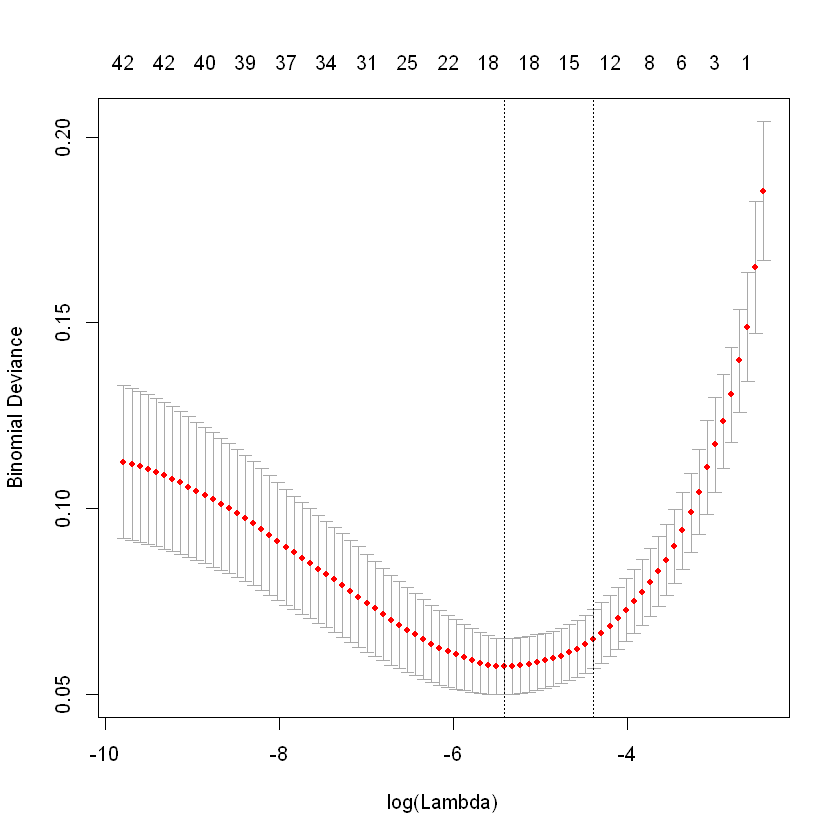

In [29]:
# Perform LASSO regression with cross-validation
set.seed(123)  # For reproducibility
lasso_model <- cv.glmnet(
  X, y, 
  family = "binomial",    # For logistic regression
  alpha = 1,              # alpha = 1 corresponds to LASSO
  nfolds = 5
)

plot(lasso_model)

In [30]:
# Optimal lambda for LASSO regression
lambda_lasso <- lasso_model$lambda.min
cat("Optimal lambda for LASSO regression (from cross-validation):", lambda_lasso, "\n")

Optimal lambda for LASSO regression (from cross-validation): 0.00446971 


In [31]:
lambda_lasso_manual <- 0.01
cat("Manual lambda for LASSO regression:", lambda_lasso_manual, "\n")

Manual lambda for LASSO regression: 0.01 


In [32]:
# Marek B. request
lambda_lasso_manual <- 0.004
cat("Manual lambda for LASSO regression:", lambda_lasso_manual, "\n")

Manual lambda for LASSO regression: 0.004 


**NOTE:** Adjusting lambda for **LASSO**
- The optimal lambda from cross-validation leads to a model with one negative coefficient.
- Therefore, I proposed my own lambda with slightly higher penalization.
- The difference between the cross-validated (red) and manually (blue) chosen lambda can be seen in the following figure:

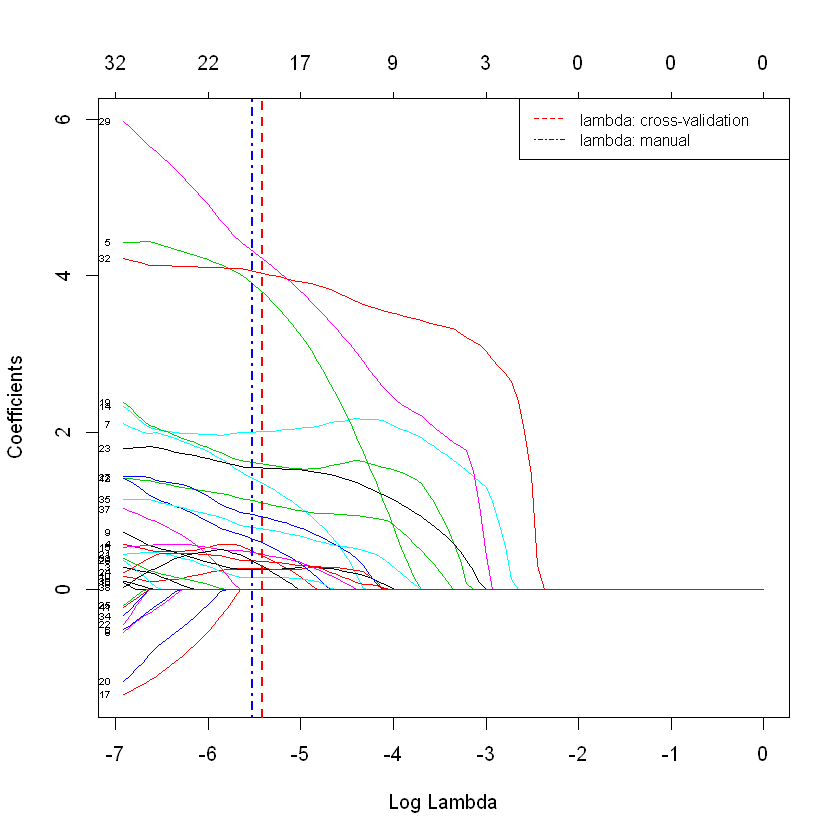

In [33]:
# Save to file
#pdf("img/lr_lasso_lambda_v2.pdf", width = 5, height = 5)

lambda_seq <- 10^seq(0, log10(0.001), length.out = 100)
fit_lasso <- glmnet(X, y, 
                    family = "binomial",  # logistic regression
                    alpha = 1,            # Lasso
                    lambda = lambda_seq
)
plot(fit_lasso, xvar="lambda", label=TRUE)
abline(v = log(lambda_lasso), col = "red", lty = 2, lwd = 2) 
abline(v = log(lambda_lasso_manual), col = "blue", lty = 4, lwd = 2) 

legend("topright",
       legend = c("lambda: cross-validation", "lambda: manual"),
       col = c("red", "blue"),
       lty = c(2, 4), 
       cex = 0.8)

# Close the graphics device
#dev.off()

**NOTE:** Why the manual lambda was chosen:
- Avoid negative coefficients in `model_lasso_final`.
- The extra omitted features had low beta values.

#### LASSO model postprocessing

**Note:**
- At the end of this notebook, I automatically save all model coefficients into `.txt` files (folder `'R_log'`). I need these files to recover the model coefficients.
- The problem is that I implemented a function that saves only the output of `summary()`, but the LASSO model has no `summary()` function.
- I solved this as follows: I fit a standard regression model with all features (a fake LASSO model), then I replace its coefficients with the actual coefficients from the LASSO model. When I call `summary()` on this fake LASSO model, it displays the real LASSO coefficients instead of the fake ones. -> This allows me to call `summary()` and see the correct LASSO coefficients. BINGO.
- That’s what I do in the following cells.

In [34]:
# Get the coefficients of the model at the optimal lambda
coef_lasso <- coef(fit_lasso, s = lambda_lasso_manual)
print(coef_lasso)

43 x 1 sparse Matrix of class "dgCMatrix"
                                          1
(Intercept)                      -5.8053931
imy.iz.Nxn                        .        
Hry.cStA                          .        
Xry.Hbt                           .        
iwn.knmwt                         0.4897158
zA.ncwt.n.Xt.f.cmcw               3.8996908
imy.rA.gc.pr                      .        
aD.mr.8p                          1.4197696
wt.y..Inpw                        .        
imy.rA.Snwty                      0.2459091
imy.rA.5maw                       0.2618584
imAxw                             .        
imy.rA.prwy.HD                    1.1263520
imy.rA.izwy..n..Xkr.w..ncwt       0.6421613
Xry.Hbt.Hry.tp                    2.0004738
cmr.waty                          0.4634400
imy.rA.prwy.nbw                   .        
r.P.nb                            .        
zS.mDAt.nTr                       .        
zA.ncwt.n.Xt.f                    1.6147127
Hry.tp.Nxb                        

In [35]:
# Convert coefficients to a matrix
coef_lasso_2 <- as.matrix(coef_lasso)
# Extract names of predictors with non-zero coefficients
non_zero_lasso_features <- rownames(coef_lasso_2)[coef_lasso_2 != 0]
# Add missing required features
# non_zero_lasso_features <- setdiff(non_zero_lasso_features, required_features)
# non_zero_lasso_features <- c(non_zero_lasso_features, required_features)
# Exclude intercept if needed
non_zero_lasso_features <- non_zero_lasso_features[non_zero_lasso_features != "(Intercept)"]
non_zero_lasso_features

[1] "iwn.knmwt"                        "zA.ncwt.n.Xt.f.cmcw"             
 [3] "aD.mr.8p"                         "imy.rA.Snwty"                    
 [5] "imy.rA.5maw"                      "imy.rA.prwy.HD"                  
 [7] "imy.rA.izwy..n..Xkr.w..ncwt"      "Xry.Hbt.Hry.tp"                  
 [9] "cmr.waty"                         "zA.ncwt.n.Xt.f"                  
[11] "Hry.cStA.n.wD.t..mdw.nbt.nt.ncwt" "imy.rA.kAt.nbt..nt..ncwt"        
[13] "aA.8wAw"                          "xrp.SnDt.nbt"                    
[15] "wr.5..m..pr.9Hwty"                "imy.rA.zS.w..a.w...nw..ncwt"     
[17] "xtm.ty..bity"                     "mDH.ncwt.qd.w..m.prwy"

In [36]:
# Assuming 'X' is your predictor matrix and 'df' is your original data
X_lasso <- data[, non_zero_lasso_features, drop = FALSE]
# Combine the reduced predictors with the response variable
df_lasso <- cbind(X_lasso, target = y)
head(df_lasso)

iwn.knmwt,zA.ncwt.n.Xt.f.cmcw,aD.mr.8p,imy.rA.Snwty,imy.rA.5maw,imy.rA.prwy.HD,imy.rA.izwy..n..Xkr.w..ncwt,Xry.Hbt.Hry.tp,cmr.waty,zA.ncwt.n.Xt.f,Hry.cStA.n.wD.t..mdw.nbt.nt.ncwt,imy.rA.kAt.nbt..nt..ncwt,aA.8wAw,xrp.SnDt.nbt,wr.5..m..pr.9Hwty,imy.rA.zS.w..a.w...nw..ncwt,xtm.ty..bity,mDH.ncwt.qd.w..m.prwy,target
0,0,0,1,0,1,1,1,1,0,0,1,0,1,0,1,1,0,1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
# Fit the final LASSO regression model
model_lasso_final <- glm(target ~ ., data = df_lasso, family = "binomial")
summary(model_lasso_final)


Call:
glm(formula = target ~ ., family = "binomial", data = df_lasso)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9082  -0.0551  -0.0551  -0.0551   3.6031  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                        -6.4896     0.4287 -15.137  < 2e-16 ***
iwn.knmwt1                          1.1215     0.9195   1.220   0.2226    
zA.ncwt.n.Xt.f.cmcw1                5.0382     1.1618   4.336 1.45e-05 ***
aD.mr.8p1                           2.0812     1.1318   1.839   0.0659 .  
imy.rA.Snwty1                       0.3238     1.0042   0.322   0.7471    
imy.rA.5maw1                        0.3364     1.1413   0.295   0.7682    
imy.rA.prwy.HD1                     1.4867     1.0000   1.487   0.1371    
imy.rA.izwy..n..Xkr.w..ncwt1        1.2206     1.1798   1.035   0.3008    
Xry.Hbt.Hry.tp1                     1.9639     1.0174   1.930   0.0536 .  
cmr.waty1                           0.7056     0.7

In [38]:
# Factorial variables have suffix '1' in the summary(lm). This function removes the suffix (if reasonable)
smart_strip_factor_suffix <- function(features, data) {
  cleaned <- sapply(features, function(f) {
    # if feature in data -> return feature
    if (f %in% colnames(data)) {
      return(f)
    # if feature not in data
    } else {
      # remove its last character (should be '1' symbolizing factor level)
      f_trim <- substr(f, 1, nchar(f) - 1)
      # if feature witout last chat in data -> return trimmed feature
      if (f_trim %in% colnames(data)) {
        return(f_trim)
      # no match -> return original feature
      } else {
        return(f)
      }
    }
  }, USE.NAMES = FALSE)
  
  return(cleaned)
}

In [39]:
# Convert to named numeric vector
lasso_coefs_vec <- as.vector(coef_lasso)
names(lasso_coefs_vec) <- rownames(coef_lasso)

# Identify missing required_features
missing <- setdiff(required_features, names(lasso_coefs_vec))

# Add missing required_features with value 0
if (length(missing) > 0) {
  lasso_coefs_vec[missing] <- 0
}

# Make sure glm_model and ridge_model coefficients match in names
# You can reorder ridge coefficients to match glm_model if needed
feature_order <- smart_strip_factor_suffix(names(model_lasso_final$coefficients), data)
lasso_coefs_vec <- lasso_coefs_vec[feature_order]

# Assign ridge coefficients to glm model
model_lasso_final$coefficients <- lasso_coefs_vec
summary(model_lasso_final)


Call:
glm(formula = target ~ ., family = "binomial", data = df_lasso)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9082  -0.0551  -0.0551  -0.0551   3.6031  

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       -5.8054     0.4287 -13.542  < 2e-16 ***
iwn.knmwt                          0.4897     0.9195   0.533 0.594322    
zA.ncwt.n.Xt.f.cmcw                3.8997     1.1618   3.357 0.000789 ***
aD.mr.8p                           1.4198     1.1318   1.254 0.209675    
imy.rA.Snwty                       0.2459     1.0042   0.245 0.806555    
imy.rA.5maw                        0.2619     1.1413   0.229 0.818523    
imy.rA.prwy.HD                     1.1264     1.0000   1.126 0.260030    
imy.rA.izwy..n..Xkr.w..ncwt        0.6422     1.1798   0.544 0.586226    
Xry.Hbt.Hry.tp                     2.0005     1.0174   1.966 0.049276 *  
cmr.waty                           0.4634     0.7165   0.647

**NOTE:**
- This summary includes `'Std. Error'`, `'z value'`, and `'Pr(>|z|)'` from the **fake LASSO model**.
- BUT the `'Estimate'` values are now set to those from the **real LASSO model**.
- I only need it to store the real model coefficients — not the p-values. So I can save the summary from the fake Ridge model.

In [40]:
# Check feature order
all(feature_order == names(lasso_coefs_vec))

[1] TRUE

### Ridge model

In [41]:
# Split the data into predictors (X) and response (y)
X <- as.matrix(data[, setdiff(names(data), "vizier")])
X <- as(X, "dgCMatrix")
y <- as.factor(data$vizier)

In [42]:
library(Matrix)
X <- as(X, "dgCMatrix")

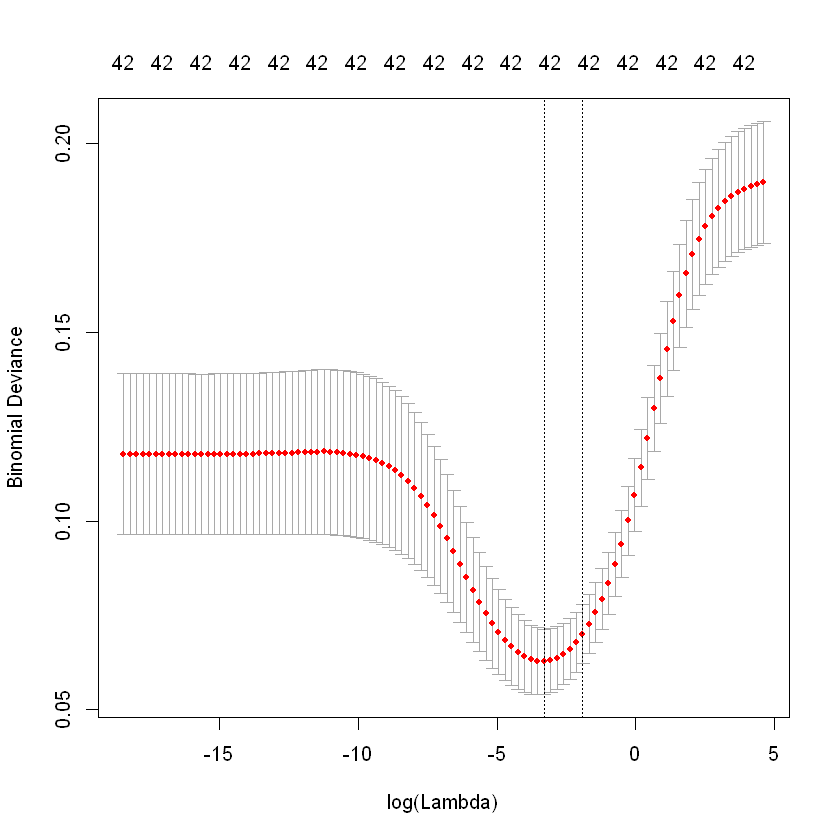

In [43]:
# Perform RIDGE regression with cross-validation
set.seed(123)  # For reproducibility
lambda_seq <- 10^seq(-8, 2, length = 100)
ridge_model <- cv.glmnet(
  X, y, 
  family = "binomial",    # For logistic regression
  alpha = 0,              # alpha = 0 corresponds to RIDGE
  lambda = lambda_seq,
  nfolds = 5
)

plot(ridge_model)

In [44]:
# Optimal lambda for RIDGE regression
lambda_ridge <- ridge_model$lambda.min
cat("Optimal lambda for RIDGE regression (from cross-validation):", lambda_ridge, "\n")

Optimal lambda for RIDGE regression (from cross-validation): 0.0367838 


In [45]:
lambda_ridge_manual <- 0.17
cat("Manual lambda for RIDGE regression:", lambda_ridge_manual, "\n")

Manual lambda for RIDGE regression: 0.17 


In [46]:
# Marek B. request
lambda_ridge_manual <- 0.14
cat("Manual lambda for RIDGE regression:", lambda_ridge_manual, "\n")

Manual lambda for RIDGE regression: 0.14 


**NOTE:** Adjusting lambda for **RIDGE**
- The optimal lambda from cross-validation leads to a model with relatively many negative coefficients.
- Therefore, I proposed my own lambda with higher penalization.
- The difference between the cross-validated (red) and manually (blue) chosen lambda can be seen in the following figure:

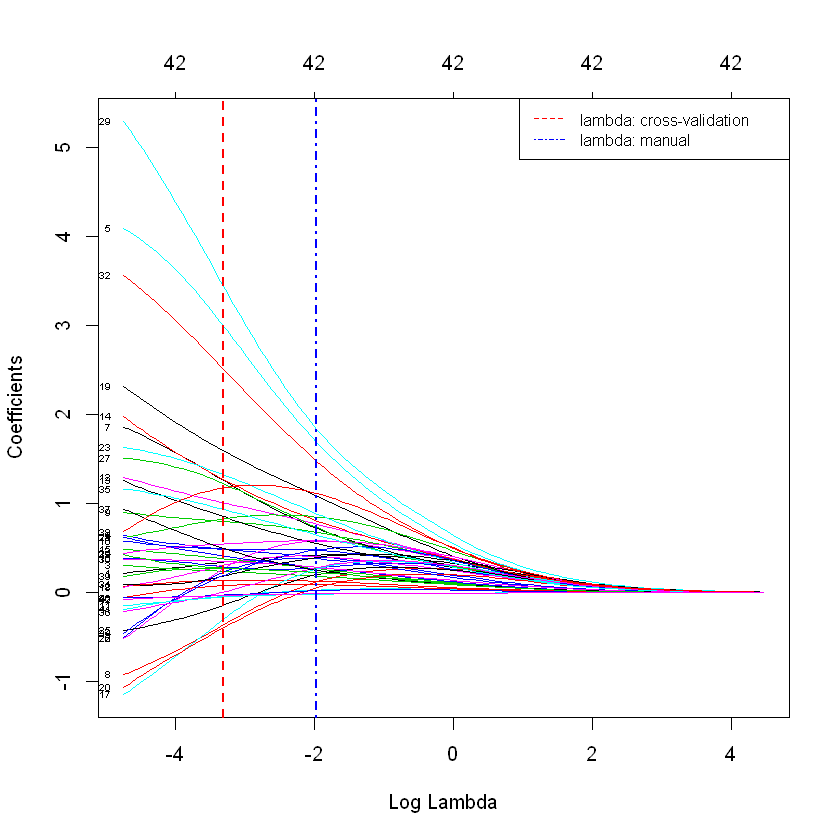

In [47]:
# Save to file
#pdf("img/lr_ridge_lambda_v2.pdf", width = 5, height = 5)

lambda_seq <- 10^seq(0.1, log10(0.01), length.out = 100)
fit_ridge <- glmnet(X, y, 
                    family = "binomial",  # logistic regression
                    alpha = 0,            # RIDGE
                    #lambda = lambda_seq
)
plot(fit_ridge, xvar="lambda", label=TRUE)
abline(v = log(lambda_ridge), col = "red", lty = 2, lwd = 2)  
abline(v = log(lambda_ridge_manual), col = "blue", lty = 4, lwd = 2) 

legend("topright",
       legend = c("lambda: cross-validation", "lambda: manual"),
       col = c("red", "blue"),
       lty = c(2, 4), 
       cex = 0.8)

# Close the graphics device
#dev.off()

**NOTE:** The **glmnet** documentation states:
- **standardize:** The coefficients are always returned on the original scale.
- Therefore, setting `standardize=True` (the default) does **not** affect the shape of the returned coefficients.
- See the **glmnet** documentation:

In [48]:
?glmnet

glmnet {glmnet},R Documentation
x,"input matrix, of dimension nobs x nvars; each row is an observation vector. Can be in sparse matrix format (inherit from class ""sparseMatrix"" as in package Matrix; not yet available for family=""cox"")"
y,"response variable. Quantitative for family=""gaussian"", or family=""poisson"" (non-negative counts). For family=""binomial"" should be either a factor with two levels, or a two-column matrix of counts or proportions (the second column is treated as the target class; for a factor, the last level in alphabetical order is the target class). For family=""multinomial"", can be a nc>=2 level factor, or a matrix with nc columns of counts or proportions. For either ""binomial"" or ""multinomial"", if y is presented as a vector, it will be coerced into a factor. For family=""cox"", y should be a two-column matrix with columns named 'time' and 'status'. The latter is a binary variable, with '1' indicating death, and '0' indicating right censored. The function Surv() in package survival produces such a matrix. For family=""mgaussian"", y is a matrix of quantitative responses."
family,Response type (see above)
weights,observation weights. Can be total counts if responses are proportion matrices. Default is 1 for each observation
offset,"A vector of length nobs that is included in the linear predictor (a nobs x nc matrix for the ""multinomial"" family). Useful for the ""poisson"" family (e.g. log of exposure time), or for refining a model by starting at a current fit. Default is NULL. If supplied, then values must also be supplied to the predict function."
alpha,"The elasticnet mixing parameter, with 0≤α≤ 1. The penalty is defined as (1-α)/2||β||_2^2+α||β||_1. alpha=1 is the lasso penalty, and alpha=0 the ridge penalty."
nlambda,The number of lambda values - default is 100.
lambda.min.ratio,"Smallest value for lambda, as a fraction of lambda.max, the (data derived) entry value (i.e. the smallest value for which all coefficients are zero). The default depends on the sample size nobs relative to the number of variables nvars. If nobs > nvars, the default is 0.0001, close to zero. If nobs < nvars, the default is 0.01. A very small value of lambda.min.ratio will lead to a saturated fit in the nobs < nvars case. This is undefined for ""binomial"" and ""multinomial"" models, and glmnet will exit gracefully when the percentage deviance explained is almost 1."
lambda,"A user supplied lambda sequence. Typical usage is to have the program compute its own lambda sequence based on nlambda and lambda.min.ratio. Supplying a value of lambda overrides this. WARNING: use with care. Avoid supplying a single value for lambda (for predictions after CV use predict() instead). Supply instead a decreasing sequence of lambda values. glmnet relies on its warms starts for speed, and its often faster to fit a whole path than compute a single fit."
standardize,"Logical flag for x variable standardization, prior to fitting the model sequence. The coefficients are always returned on the original scale. Default is standardize=TRUE. If variables are in the same units already, you might not wish to standardize. See details below for y standardization with family=""gaussian""."


In [49]:
# Get the coefficients of the model at the optimal lambda
coef_ridge <-  coef(fit_ridge, s = lambda_ridge_manual)
print(coef_ridge)

43 x 1 sparse Matrix of class "dgCMatrix"
                                           1
(Intercept)                      -5.07030422
imy.iz.Nxn                        0.42238846
Hry.cStA                          0.13107873
Xry.Hbt                           0.18623913
iwn.knmwt                         0.40655476
zA.ncwt.n.Xt.f.cmcw               1.69396833
imy.rA.gc.pr                      0.57753192
aD.mr.8p                          0.72487894
wt.y..Inpw                        0.12044569
imy.rA.Snwty                      0.67970608
imy.rA.5maw                       0.47811887
imAxw                             0.03040998
imy.rA.prwy.HD                    0.77201742
imy.rA.izwy..n..Xkr.w..ncwt       0.55549835
Xry.Hbt.Hry.tp                    0.81088013
cmr.waty                          0.27128003
imy.rA.prwy.nbw                   0.28255862
r.P.nb                            0.26289353
zS.mDAt.nTr                       0.40941266
zA.ncwt.n.Xt.f                    1.08609066
Hry.tp.Nxb   

#### Ridge model postprocessing

**Note:**
- At the end of this notebook, I automatically save all model coefficients into `.txt` files (folder `'R_log'`). I need these files to recover the model coefficients.
- The problem is that I implemented a function that saves only the output of `summary()`, but the Ridge model has no `summary()` function.
- I solved this as follows: I fit a standard regression model with all features (a fake Ridge model), then I replace its coefficients with the actual coefficients from the Ridge model. When I call `summary()` on this fake Ridge model, it displays the real Ridge coefficients instead of the fake ones. -> This allows me to call `summary()` and see the correct Ridge coefficients. BINGO.
- That’s what I do in the following cells.

In [50]:
# Convert coefficients to a matrix
coef_ridge_2 <- as.matrix(coef_ridge)
# Extract names of predictors with non-zero coefficients
non_zero_ridge_features <- rownames(coef_ridge_2)[coef_ridge_2 != 0]
# Add missing required features
non_zero_ridge_features <- setdiff(non_zero_ridge_features, required_features)
non_zero_ridge_features <- c(non_zero_ridge_features, required_features)
# Exclude intercept if needed
non_zero_ridge_features <- non_zero_ridge_features[non_zero_ridge_features != "(Intercept)"]
non_zero_ridge_features

[1] "imy.iz.Nxn"                       "Hry.cStA"                        
 [3] "Xry.Hbt"                          "iwn.knmwt"                       
 [5] "zA.ncwt.n.Xt.f.cmcw"              "imy.rA.gc.pr"                    
 [7] "aD.mr.8p"                         "wt.y..Inpw"                      
 [9] "imy.rA.Snwty"                     "imy.rA.5maw"                     
[11] "imAxw"                            "imy.rA.prwy.HD"                  
[13] "imy.rA.izwy..n..Xkr.w..ncwt"      "Xry.Hbt.Hry.tp"                  
[15] "cmr.waty"                         "imy.rA.prwy.nbw"                 
[17] "r.P.nb"                           "zS.mDAt.nTr"                     
[19] "zA.ncwt.n.Xt.f"                   "Hry.tp.Nxb"                      
[21] "Hry.cStA.n.wD.t..mdw.nbt.nt.ncwt" "zA.ncwt"                         
[23] "imy.rA.kAt.nbt..nt..ncwt"         "aA.8wAw"                         
[25] "imA.a"                            "X.imAxw.xr..nTr.aA"              
[27] "xrp.SnDt.nbt"                     "xrp.aH"                          
[29] "wr.5..m..pr.9Hwty"                "Hry.cStA.n.pr.dwAt"              
[31] "xrp.iAwt.nbwt.nTrwt"              "imy.rA.zS.w..a.w...nw..ncwt"     
[33] "Xry.tp.ncwt"                      "mDH.zS.w..ncwt"                  
[35] "xtm.ty..bity"                     "imy.iz"                          
[37] "imAxw.xr.Wcir"                    "mDH.ncwt.qd.w..m.prwy"           
[39] "aD.mr..n..zAb"                    "father_was_vizier"               
[41] "dynasty_1"                        "PC2"

In [51]:
# Assuming 'X' is your predictor matrix and 'df' is your original data
X_ridge <- data[, non_zero_ridge_features, drop = FALSE]
# Combine the reduced predictors with the response variable
df_ridge <- cbind(X_ridge, target = y)
head(df_ridge)

imy.iz.Nxn,Hry.cStA,Xry.Hbt,iwn.knmwt,zA.ncwt.n.Xt.f.cmcw,imy.rA.gc.pr,aD.mr.8p,wt.y..Inpw,imy.rA.Snwty,imy.rA.5maw,...,mDH.zS.w..ncwt,xtm.ty..bity,imy.iz,imAxw.xr.Wcir,mDH.ncwt.qd.w..m.prwy,aD.mr..n..zAb,father_was_vizier,dynasty_1,PC2,target
0,0,1,0,0,0,0,1,1,0,...,0,1,0,1,0,0,0,1,-2.3526672,1
0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-0.2529617,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-0.2445983,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-0.9566737,0
0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-0.5573091,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-0.7393621,0


In [52]:
# Fit the final LASSO regression model
model_ridge_final <- glm(target ~ ., data = df_ridge, family = "binomial")
summary(model_ridge_final)


Call:
glm(formula = target ~ ., family = "binomial", data = df_ridge)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2520  -0.0564  -0.0455  -0.0275   3.5800  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       -6.51010    0.55151 -11.804  < 2e-16 ***
imy.iz.Nxn1                        0.02399    1.80055   0.013  0.98937    
Hry.cStA1                         -0.10127    1.18868  -0.085  0.93211    
Xry.Hbt1                           0.50824    1.08696   0.468  0.64009    
iwn.knmwt1                         1.02887    1.27122   0.809  0.41831    
zA.ncwt.n.Xt.f.cmcw1               4.63353    1.47177   3.148  0.00164 ** 
imy.rA.gc.pr1                     -1.75166    1.41057  -1.242  0.21431    
aD.mr.8p1                          2.51338    1.82647   1.376  0.16879    
wt.y..Inpw1                       -1.37632    1.86943  -0.736  0.46159    
imy.rA.Snwty1                      1.29307    1.12

In [53]:
# Convert to named numeric vector
ridge_coefs_vec <- as.vector(coef_ridge)
names(ridge_coefs_vec) <- rownames(coef_ridge)

# Identify missing required_features
missing <- setdiff(required_features, names(lasso_coefs_vec))

# Add missing required_features with value 0
if (length(missing) > 0) {
  lasso_coefs_vec[missing] <- 0
}

# Make sure glm_model and ridge_model coefficients match in names
# You can reorder ridge coefficients to match glm_model if needed
feature_order <- smart_strip_factor_suffix(names(model_ridge_final$coefficients), data)
ridge_coefs_vec <- ridge_coefs_vec[feature_order]

# Assign ridge coefficients to glm model
model_ridge_final$coefficients <- ridge_coefs_vec
summary(model_ridge_final)


Call:
glm(formula = target ~ ., family = "binomial", data = df_ridge)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2520  -0.0564  -0.0455  -0.0275   3.5800  

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      -5.07030    0.55151  -9.193   <2e-16 ***
imy.iz.Nxn                        0.42239    1.80055   0.235    0.815    
Hry.cStA                          0.13108    1.18868   0.110    0.912    
Xry.Hbt                           0.18624    1.08696   0.171    0.864    
iwn.knmwt                         0.40655    1.27122   0.320    0.749    
zA.ncwt.n.Xt.f.cmcw               1.69397    1.47177   1.151    0.250    
imy.rA.gc.pr                      0.57753    1.41057   0.409    0.682    
aD.mr.8p                          0.72488    1.82647   0.397    0.691    
wt.y..Inpw                        0.12045    1.86943   0.064    0.949    
imy.rA.Snwty                      0.67971    1.12663   0.603

**NOTE:**
- This summary includes `'Std. Error'`, `'z value'`, and `'Pr(>|z|)'` from the **fake Ridge model**.
- BUT the `'Estimate'` values are now set to those from the **real Ridge model**.
- I only need it to store the real model coefficients — not the p-values. So I can save the summary from the fake Ridge model.

In [54]:
# Check feature order
all(feature_order == names(ridge_coefs_vec))

[1] TRUE

### Save models

**NOTE:** This section saves the `summary()` output into folder `path_save`.

In [55]:
path_save = 'R_log/'

In [56]:
path_data = cbind(path_train, path_val)
path_data = path_train
path_data

[1] "C:/Users/Stoja/OneDrive/Documents/diplomka/scr/data/df_vizier_train_v2_2.csv"

In [57]:
# Summary of the model
summary <- save_summary(step_model, 'glm_vizier_vs_title_step_v2', path_save, path_data)

In [58]:
# Summary of the model
summary <- save_summary(model_lasso_final, 'glm_vizier_vs_title_lasso_v2', path_save, path_data)

In [59]:
# Summary of the model
summary <- save_summary(model_ridge_final, 'glm_vizier_vs_title_ridge_v2', path_save, path_data)

### Make a summary csv file

**NOTE:**
- This section calls a Python script that performs postprocessing on the `.txt` summary files
- It creates a single Excel file containing coefficients from all models.

In [60]:
# See current working directory
wd <- getwd()
print(wd)

# Set working directory to python file location
setwd("../../")
print(getwd())

# See python version
python_version <- system("python --version", intern = TRUE)
print(python_version)

# Run python file
output <- system("python analyze_R_log.py --version _v2", intern = TRUE)
print(output)

# Set working directory back
setwd(wd)
print(getwd())

[1] "C:/Users/Stoja/OneDrive/Documents/diplomka/scr/jupyter_notebook/R_script"
[1] "C:/Users/Stoja/OneDrive/Documents/diplomka/scr"
[1] "Python 3.11.8"
[1] "The version you entered is: '_v2'"                                                  
[2] "CSV file loaded."                                                                   
[3] "C:\\Users\\Stoja\\OneDrive\\Documents\\diplomka\\scr\\data\\df_title_name_r_map.csv"
[4] "Excel file saved successfully!"                                                     
[1] "C:/Users/Stoja/OneDrive/Documents/diplomka/scr/jupyter_notebook/R_script"
